<a href="https://colab.research.google.com/github/marco-milanesi/deep-learning/blob/main/neural-network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

In [2]:
!wget https://www.kasprowski.pl/datasets/weather.zip

--2021-11-09 15:09:32--  https://www.kasprowski.pl/datasets/weather.zip
Resolving www.kasprowski.pl (www.kasprowski.pl)... 94.152.164.213
Connecting to www.kasprowski.pl (www.kasprowski.pl)|94.152.164.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95380686 (91M) [application/zip]
Saving to: ‘weather.zip’

weather.zip         100%[===================>]  90.96M  11.2MB/s    in 8.4s    

2021-11-09 15:09:41 (10.8 MB/s) - ‘weather.zip’ saved [95380686/95380686]



In [ ]:
!unzip weather.zip

# Image classification between 2 classes

In [4]:
import cv2
import os
def load_img(indir):
    samples = []
    labels = []
    for class_dir in os.listdir(indir):
        if not os.path.isdir(indir+'/'+class_dir): 
          continue
        if class_dir == 'rain' or class_dir == 'shine':
          continue  
        print("Loading:",class_dir)
        the_class = class_dir
        for file in os.listdir(indir+'/'+class_dir):
            image = cv2.imread("{}/{}/{}".format(indir,class_dir,file))
            image = cv2.resize(image, (64,64))
            samples.append(image)
            labels.append(the_class)
    samples = np.array(samples)
    labels = np.array(labels)
    return samples,labels
samples, labels = load_img('weather')
print('loaded',len(samples),' samples')
print('classes',set(labels))
org_samples = samples
org_labels = labels

Loading: cloudy
Loading: sunrise
loaded 657  samples
classes {'sunrise', 'cloudy'}


### Show examples

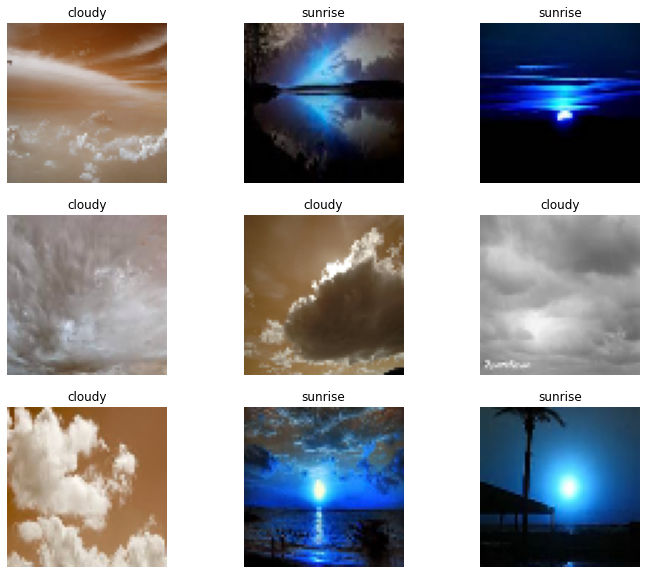

In [5]:
import matplotlib.pyplot as plt
import random
    
plt.figure(figsize=(12, 10))
for i in range(9):
    n = random.randrange(len(samples))
    plt.subplot(3, 3, i + 1)
    plt.imshow(samples[n])
    plt.title(labels[n])
    plt.axis("off")

### One-hot labels

In [6]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print("Labels shape",labels.shape)
labels = labels.astype(float)

Labels shape (657, 1)


### Train-test split

In [7]:
print(samples.shape)
import sklearn.model_selection
(trainSamples, testSamples, trainLabels, testLabels) = sklearn.model_selection.train_test_split(samples,labels,random_state=22)


(657, 64, 64, 3)


# CNN

In [8]:
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
model = Sequential()
model.add(Conv2D(16, (3, 3), padding="same",input_shape=(64,64,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.summary()
optimizer = tf.keras.optimizers.RMSprop(0.0001, decay = 1e-6)
model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0

In [9]:
H = model.fit(trainSamples, trainLabels, epochs=20, validation_data=(testSamples,testLabels))

Epoch 1/20
16/16 [==============================] - 5s 212ms/step - loss: 0.7660 - accuracy: 0.7846 - val_loss: 3.5701 - val_accuracy: 0.5212
Epoch 2/20
16/16 [==============================] - 3s 198ms/step - loss: 0.1372 - accuracy: 0.9492 - val_loss: 1.3123 - val_accuracy: 0.5939
Epoch 3/20
16/16 [==============================] - 3s 202ms/step - loss: 0.2314 - accuracy: 0.9228 - val_loss: 0.1447 - val_accuracy: 0.9455
Epoch 4/20
16/16 [==============================] - 3s 197ms/step - loss: 0.0773 - accuracy: 0.9675 - val_loss: 0.0297 - val_accuracy: 1.0000
Epoch 5/20
16/16 [==============================] - 3s 197ms/step - loss: 0.0307 - accuracy: 0.9898 - val_loss: 0.1810 - val_accuracy: 0.9333
Epoch 6/20
16/16 [==============================] - 3s 194ms/step - loss: 0.0670 - accuracy: 0.9756 - val_loss: 0.3287 - val_accuracy: 0.8545
Epoch 7/20
16/16 [==============================] - 3s 198ms/step - loss: 0.0371 - accuracy: 0.9817 - val_loss: 0.0740 - val_accuracy: 0.9636
Epoch 

### Show result

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score

testResults = model.predict(testSamples)
# Change the result from float to 0 and 1
for i in range(len(testResults)):
    if testResults[i] > 0.5:
      testResults[i] = 1
    else:
      testResults[i] = 0

print(testResults.T)

print(confusion_matrix(testLabels, testResults))
print(classification_report(testLabels, testResults))
print("Cohen's Kappa: {}".format(cohen_kappa_score(testLabels, testResults)))
print("Accuracy: ",accuracy_score(testLabels, testResults))

[[1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0.
  0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0.
  1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1.
  0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0.
  0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1.]]
[[79  0]
 [11 75]]
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93        79
         1.0       1.00      0.87      0.93        86

    accuracy                           0.93       165
   macro avg       0.94      0.94      0.93       165
weighted avg       0.94      0.93      0.93       165

Cohen's Kappa: 0.867178924259056
Accuracy:  0.9333333333333333


# Image classification between 4 classes

In [24]:
import cv2
import os
def load_img(indir):
    samples = []
    labels = []
    for class_dir in os.listdir(indir):
        if not os.path.isdir(indir+'/'+class_dir): 
          continue
        print("Loading:",class_dir)
        the_class = class_dir
        for file in os.listdir(indir+'/'+class_dir):
            image = cv2.imread("{}/{}/{}".format(indir,class_dir,file))
            image = cv2.resize(image, (64,64))
            samples.append(image)
            labels.append(the_class)
    samples = np.array(samples)
    labels = np.array(labels)
    return samples,labels
samples, labels = load_img('weather')
print('loaded',len(samples),' samples')
print('classes',set(labels))
org_samples = samples
org_labels = labels

Loading: cloudy
Loading: shine
Loading: rain
Loading: sunrise
loaded 1123  samples
classes {'sunrise', 'shine', 'cloudy', 'rain'}


### Show examples

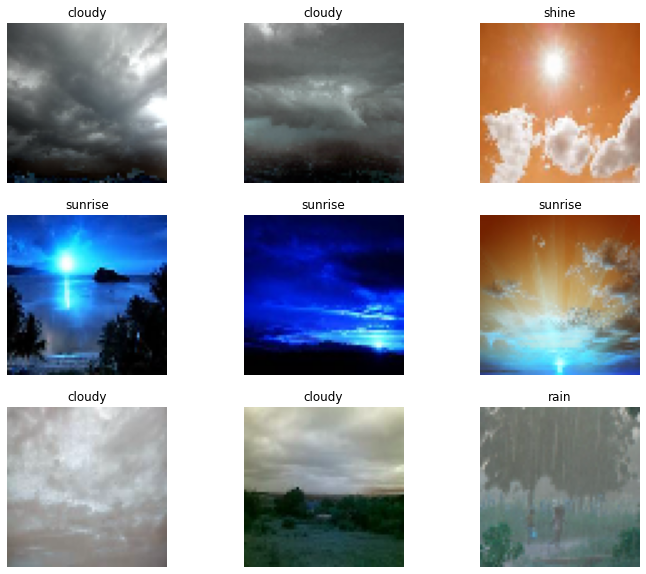

In [25]:
import matplotlib.pyplot as plt
import random
    
plt.figure(figsize=(12, 10))
for i in range(9):
    n = random.randrange(len(samples))
    plt.subplot(3, 3, i + 1)
    plt.imshow(samples[n])
    plt.title(labels[n])
    plt.axis("off")

### One-hot labels

In [26]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print("Labels shape",labels.shape)
labels = labels.astype(float)

Labels shape (1123, 4)


### Train-test split

In [27]:
print(samples.shape)
import sklearn.model_selection
(trainSamples, testSamples, trainLabels, testLabels) = sklearn.model_selection.train_test_split(samples,labels,random_state=22)

(1123, 64, 64, 3)


In [28]:
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
model = Sequential()
model.add(Conv2D(16, (3, 3), padding="same",input_shape=(64,64,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dense(4))
model.add(Activation("softmax"))

model.summary()
optimizer = tf.keras.optimizers.RMSprop(0.0001, decay = 1e-6)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
batch_normalization_6 (Batch (None, 64, 64, 16)        64        
_________________________________________________________________
activation_12 (Activation)   (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 32)       

In [31]:
H = model.fit(trainSamples, trainLabels, epochs=20, validation_data=(testSamples,testLabels))

Epoch 1/20
27/27 [==============================] - 6s 219ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.3461 - val_accuracy: 0.9217
Epoch 2/20
27/27 [==============================] - 6s 216ms/step - loss: 0.0274 - accuracy: 0.9941 - val_loss: 0.4713 - val_accuracy: 0.9075
Epoch 3/20
27/27 [==============================] - 5s 195ms/step - loss: 0.0022 - accuracy: 0.9988 - val_loss: 0.4024 - val_accuracy: 0.9146
Epoch 4/20
27/27 [==============================] - 6s 209ms/step - loss: 8.9634e-04 - accuracy: 1.0000 - val_loss: 0.3612 - val_accuracy: 0.9253
Epoch 5/20
27/27 [==============================] - 6s 218ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.4516 - val_accuracy: 0.9181
Epoch 6/20
27/27 [==============================] - 6s 214ms/step - loss: 0.0023 - accuracy: 0.9988 - val_loss: 0.5640 - val_accuracy: 0.9075
Epoch 7/20
27/27 [==============================] - 6s 216ms/step - loss: 0.0181 - accuracy: 0.9964 - val_loss: 0.3546 - val_accuracy: 0.9324
Ep

### Show results

In [32]:
testResults = model.predict(testSamples)

print(confusion_matrix(testLabels.argmax(axis=1), testResults.argmax(axis=1)))
print(classification_report(testLabels.argmax(axis=1), testResults.argmax(axis=1)))
print("Cohen's Kappa: {}".format(cohen_kappa_score(testLabels.argmax(axis=1), testResults.argmax(axis=1))))
print("Accuracy: ",accuracy_score(testLabels.argmax(axis=1), testResults.argmax(axis=1)))

[[76  0  0  0]
 [20 24  1  1]
 [10  0 54  2]
 [ 2  0  1 90]]
              precision    recall  f1-score   support

           0       0.70      1.00      0.83        76
           1       1.00      0.52      0.69        46
           2       0.96      0.82      0.89        66
           3       0.97      0.97      0.97        93

    accuracy                           0.87       281
   macro avg       0.91      0.83      0.84       281
weighted avg       0.90      0.87      0.86       281

Cohen's Kappa: 0.8185641490995393
Accuracy:  0.8683274021352313
